## Baseline Recommender: Cosine Similarity

## import

In [51]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import json
from tqdm.notebook import tqdm

from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
import gensim
from gensim.corpora.dictionary import Dictionary

import spacy
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
sw = stopwords.words("english")

In [53]:
with open(f'../data/metascript_df_ws.pickle', 'rb') as file:
    metascripts = pickle.load(file)

## prepare the data

In [54]:
descriptions = list(metascripts['description'].values)
scripts = list(metascripts['transcript'].values)
scripts_dict = dict(zip(descriptions, scripts))

In [55]:
descriptions

['Jim Gaffigan: Comedy Monster (2021) | Transcript',
 'Louis C. K.: Sorry (2021) | Transcript',
 'Drew Michael: Drew Michael (2018) | Transcript',
 'Drew Michael: Red Blue Green (2021) | Transcript',
 'Mo Amer: Mohammed in Texas (2021) | Transcript',
 'Dave Chappelle: The Closer (2021) | Transcript',
 'Kathleen Madigan: Bothering Jesus (2016) – Transcript',
 'Kathleen Madigan: Madigan Again (2013) – Transcript',
 'Phil Wang: Philly Philly Wang Wang (2021) – Transcript',
 'Tom Papa: You’re Doing Great! (2020) – Transcript',
 'Tom Papa: Human Mule (2016) – Transcript',
 'Tom Papa: Freaked Out (2013) – Transcript',
 'Bo Burnham: Inside (2021) – Transcript',
 'Tig Notaro: Boyish Girl Interrupted (2015) – Transcript',
 'Joe List: I Hate Myself (2020) – Transcript',
 'Nate Bargatze: The Greatest Average American (2021) – Transcript',
 'Brian Regan: On The Rocks (2021) – Transcript',
 'Doug Stanhope: Beer Hall Putsch (2013) – Transcript',
 'Chris Rock Total Blackout: The Tamborine Extended Cu

## calculate cosine similarities

In [56]:
def chunker(iterable, chunksize):
    for i in range(0, len(list(iterable)), chunksize):
        yield iterable[i:i+chunksize]

def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop)

nlp = spacy.load('en_core_web_md')

filtered_tokens = []
for scripts_subset in tqdm(chunker(scripts, 2), total = np.ceil(len(scripts)/2)):
    for doc in nlp.pipe(scripts_subset):
        tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        filtered_tokens.append(tokens)

  0%|          | 0/155.0 [00:00<?, ?it/s]

In [57]:
tokens_no_sw = [[token for token in tokenized_script if token not in sw] for tokenized_script in filtered_tokens]

In [58]:
scripts_counters = {description: Counter(tokenized_script) for description, tokenized_script in zip(descriptions, tokens_no_sw)}

In [69]:
scripts_df = pd.DataFrame.from_dict(scripts_counters, orient = 'columns').fillna(0).T

In [70]:
cosims = cosine_similarity(scripts_df)
cosims

array([[1.        , 0.74321527, 0.85037443, ..., 0.6067752 , 0.54536414,
        0.48503173],
       [0.74321527, 1.        , 0.70823981, ..., 0.6432108 , 0.5669992 ,
        0.52975613],
       [0.85037443, 0.70823981, 1.        , ..., 0.5147109 , 0.44384929,
        0.42579575],
       ...,
       [0.6067752 , 0.6432108 , 0.5147109 , ..., 1.        , 0.57651059,
        0.56776711],
       [0.54536414, 0.5669992 , 0.44384929, ..., 0.57651059, 1.        ,
        0.46139254],
       [0.48503173, 0.52975613, 0.42579575, ..., 0.56776711, 0.46139254,
        1.        ]])

In [71]:
cosims_df = (pd.DataFrame(index=scripts_df.index, 
                          columns=scripts_df.index, 
                          data = cosims)
        )

cosims_df.tail()

,Jim Gaffigan: Comedy Monster (2021) | Transcript,Louis C. K.: Sorry (2021) | Transcript,Drew Michael: Drew Michael (2018) | Transcript,Drew Michael: Red Blue Green (2021) | Transcript,Mo Amer: Mohammed in Texas (2021) | Transcript,Dave Chappelle: The Closer (2021) | Transcript,Kathleen Madigan: Bothering Jesus (2016) – Transcript,Kathleen Madigan: Madigan Again (2013) – Transcript,Phil Wang: Philly Philly Wang Wang (2021) – Transcript,Tom Papa: You’re Doing Great! (2020) – Transcript,...,Dave Chappelle: The Age of Spin (2017) – Transcript,GEORGE CARLIN: BACK IN TOWN (1996) – Full transcript,LOUIS C.K.: 2017 – Full transcript,George Carlin: Jamming in New York (1992) – Transcript,Reggie Watts: Spatial (2016) – Full Transcript,GEORGE CARLIN: COMPLAINTS AND GRIEVANCES (2001) – FULL TRANSCRIPT,GEORGE CARLIN: LIFE IS WORTH LOSING (2006) – Transcript,George Carlin: It’s Bad For Ya (2008) Full transcript,Dave Chappelle: 8:46 – Transcript,JIM JEFFERIES ON GUN CONTROL [FULL TRANSCRIPT]
GEORGE CARLIN: COMPLAINTS AND GRIEVANCES (2001) – FULL TRANSCRIPT,0.556646,0.616493,0.436969,0.502735,0.541851,0.554672,0.621525,0.628601,0.610585,0.684542,...,0.570157,0.741151,0.625134,0.709568,0.512572,1.000000,0.767636,0.721001,0.542498,0.519208
GEORGE CARLIN: LIFE IS WORTH LOSING (2006) – Transcript,0.563641,0.657774,0.467100,0.536353,0.540838,0.574336,0.644567,0.652744,0.654394,0.715625,...,0.586031,0.782675,0.671687,0.745401,0.538740,0.767636,1.000000,0.743997,0.563762,0.550100
George Carlin: It’s Bad For Ya (2008) Full transcript,0.606775,0.643211,0.514711,0.568402,0.582459,0.572780,0.644042,0.655741,0.613902,0.660000,...,0.585621,0.709399,0.685140,0.689901,0.555729,0.721001,0.743997,1.000000,0.576511,0.567767
Dave Chappelle: 8:46 – Transcript,0.545364,0.566999,0.443849,0.496714,0.514245,0.611179,0.566146,0.561814,0.526590,0.562394,...,0.608734,0.588764,0.595448,0.537078,0.402338,0.542498,0.563762,0.576511,1.000000,0.461393
JIM JEFFERIES ON GUN CONTROL [FULL TRANSCRIPT],0.485032,0.529756,0.425796,0.460438,0.489984,0.451589,0.533579,0.501707,0.438871,0.487809,...,0.484075,0.498587,0.532161,0.500579,0.444257,0.519208,0.550100,0.567767,0.461393,1.000000


In [72]:
cosims_df_long = (pd.DataFrame(index=scripts_df.index, 
                          columns=scripts_df.index, 
                          data = cosims)
                .melt(var_name='other_show', 
                      value_name='cosine_similarity', 
                      ignore_index=False)
                .reset_index()
                .rename(columns = {'index':'show'})
        )
cosims_df_long.head()

,show,other_show,cosine_similarity
0,Jim Gaffigan: Comedy Monster (2021) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,1.000000
1,Louis C. K.: Sorry (2021) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.743215
2,Drew Michael: Drew Michael (2018) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.850374
3,Drew Michael: Red Blue Green (2021) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.858056
4,Mo Amer: Mohammed in Texas (2021) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.807697


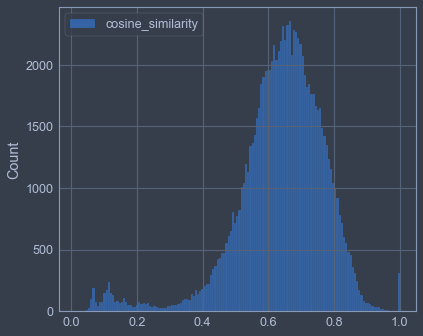

In [73]:
from jupyterthemes import jtplot
jtplot.style()

sns.histplot(cosims_df_long.sort_values('cosine_similarity', ascending = True));

In [74]:
(cosims_df_long
         [cosims_df_long['show'] != cosims_df_long['other_show']]
        .drop_duplicates(subset=['cosine_similarity'])
        .sort_values('cosine_similarity', ascending = False)[:20]
)

,show,other_show,cosine_similarity
3976,Bo Burnham: Make Happy (2016) – Transcript,Bo Burnham: Inside (2021) – Transcript,0.990612
37766,Bo Burnham: Make Happy (2016) – Transcript,Adam Sandler: 100% Fresh (2018) – Full Transcript,0.986266
3841,Adam Sandler: 100% Fresh (2018) – Full Transcript,Bo Burnham: Inside (2021) – Transcript,0.983647
47050,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,NIKKI GLASER: PERFECT (2016) – Full Transcript,0.963349
83996,Tom Segura: Mostly Stories (2016) – Transcript,Tom Segura: Completely Normal (2014) – Transcript,0.961781
30310,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,Chelsea Peretti: One of the Greats (2014) – Fu...,0.960495
30221,NIKKI GLASER: PERFECT (2016) – Full Transcript,Chelsea Peretti: One of the Greats (2014) – Fu...,0.956929
47042,Donald Glover: Weirdo (2012) – Transcript,NIKKI GLASER: PERFECT (2016) – Full Transcript,0.956021
24587,Chelsea Peretti: One of the Greats (2014) – Fu...,Nikki Glaser: Bangin’ (2019) – Full Transcript,0.954109
24730,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,Nikki Glaser: Bangin’ (2019) – Full Transcript,0.953383


In [75]:
show = 'Jim Gaffigan: Comedy Monster (2021) | Transcript'
(cosims_df_long
     [cosims_df_long['show'] != cosims_df_long['other_show']]
     [cosims_df_long['show'] == show]
     .sort_values('cosine_similarity')
)

<ipython-input-75-664380afb71d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (cosims_df_long


,show,other_show,cosine_similarity
3720,Jim Gaffigan: Comedy Monster (2021) | Transcript,Bo Burnham: Inside (2021) – Transcript,0.104616
6200,Jim Gaffigan: Comedy Monster (2021) | Transcript,"Bo Burnham: Words, Words, Words (2010) – Trans...",0.115871
79360,Jim Gaffigan: Comedy Monster (2021) | Transcript,Bo Burnham: Make Happy (2016) – Transcript,0.160376
37510,Jim Gaffigan: Comedy Monster (2021) | Transcript,Adam Sandler: 100% Fresh (2018) – Full Transcript,0.196862
55490,Jim Gaffigan: Comedy Monster (2021) | Transcript,BRIDGET EVERETT: GYNECOLOGICAL WONDER (2015) –...,0.232105
...,...,...,...
29450,Jim Gaffigan: Comedy Monster (2021) | Transcript,Demetri Martin: Live (At The Time) (2015) | Tr...,0.880536
70370,Jim Gaffigan: Comedy Monster (2021) | Transcript,JEN KIRKMAN: JUST KEEP LIVIN’? (2017) – Full T...,0.880724
42470,Jim Gaffigan: Comedy Monster (2021) | Transcript,JIM GAFFIGAN: NOBLE APE (2018) – Full Transcript,0.885646
32860,Jim Gaffigan: Comedy Monster (2021) | Transcript,Nate Bargatze: Full Time Magic (2015) – Full T...,0.890465


## pickle cosims_df for later use

In [76]:
with open('../data/cosims_df.pickle', 'wb') as file:
    pickle.dump(cosims_df, file)

## long t5 semantic similarity

In [77]:
import torch
from transformers import AutoTokenizer, LongT5ForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained("google/long-t5-local-base")

model = LongT5EncoderModel.from_pretrained("google/long-t5-local-base")

ImportError: cannot import name 'LongT5ForConditionalGeneration' from 'transformers' (C:\Users\jrior\anaconda3\lib\site-packages\transformers\__init__.py)

In [ ]:
from transformers import AutoTokenizer, LongT5Model

tokenizer = AutoTokenizer.from_pretrained("google/longt5-tglobal-large")
model = LongT5Model.from_pretrained("google/longt5-tglobal-large")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state